*프로젝트에 사용할 소리, 레이블데이터 압축풀기*

In [ ]:
!unzip -qq "/content/drive/Othercomputers/내 컴퓨터/Scream_Detection/data.zip"

# 레이블 데이터 정리

In [ ]:
from os import listdir
from os.path import join, splitext
import pandas as pd

In [ ]:
label_path = '/content/data/labels/'
label_files = [
    f for f in listdir(label_path)
    if splitext(join(label_path, f))[-1] == '.txt'
]

print(
    f'label file 목록 예시 : {label_files[:3]}'
)

label file 목록 예시 : ['백조+1+-soundbytez.txt', '3yvyd2bocme.txt', 'iuxahc-aboy.txt']


*레이블 정보 모음 파일 생성*

In [ ]:
list_file_fn = 'file_list.xlsx'  # 파일 목록 정리 엑셀 파일
file_n = 0

with pd.ExcelWriter(list_file_fn) as writer:  # 엑셀파일 읽기
    audio_names = []    # 최종 정리를 위한 빈 리스트 생성
    for i, file_name in enumerate(label_files):
        # 레이블 데이터과 소리 데이터가 매칭이 안되는 경우 에러출력
        if file_name[:-3] + 'wav' not in listdir('/content/data/raw_data/'):
            raise FileNotFoundErrorError('file not match')

        if file_name[:-3] + 'wav' in listdir('/content/data/raw_data/'):
            temp = pd.read_csv(label_path + file_name, sep='\t', header=None)
            temp.columns = ['start(s)', 'end(s)', 'label']
            temp.to_excel(writer, index=False, sheet_name=str(file_n))  # i번째 인덱스 이름의 sheet에 레이블 정보 저장
            audio_names.append(file_name[:-3] + 'wav')      # 현재 저장한 레이블에 해당하는 소리파일 목록 넣기
            file_n += 1

        if i == len(label_files) - 1:  # 마지막 반복때 모든 파일의 목록 저장
            pd.DataFrame(
                audio_names, columns=['audio_name']
            ).to_excel(writer, sheet_name='list')

한 파일에 대한 레이블 
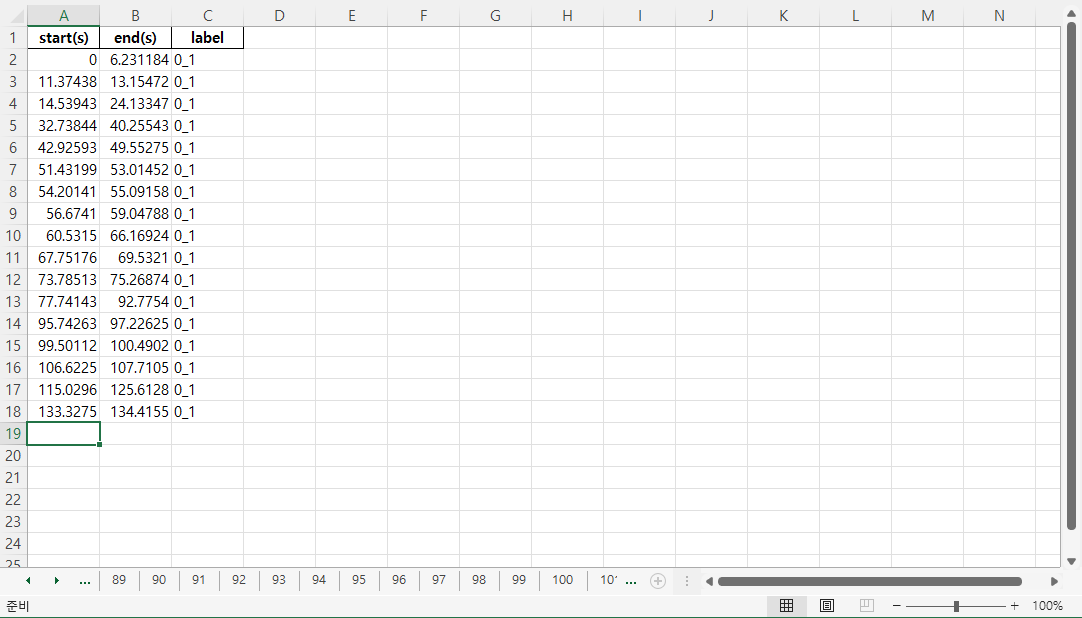

파일 리스트 정리
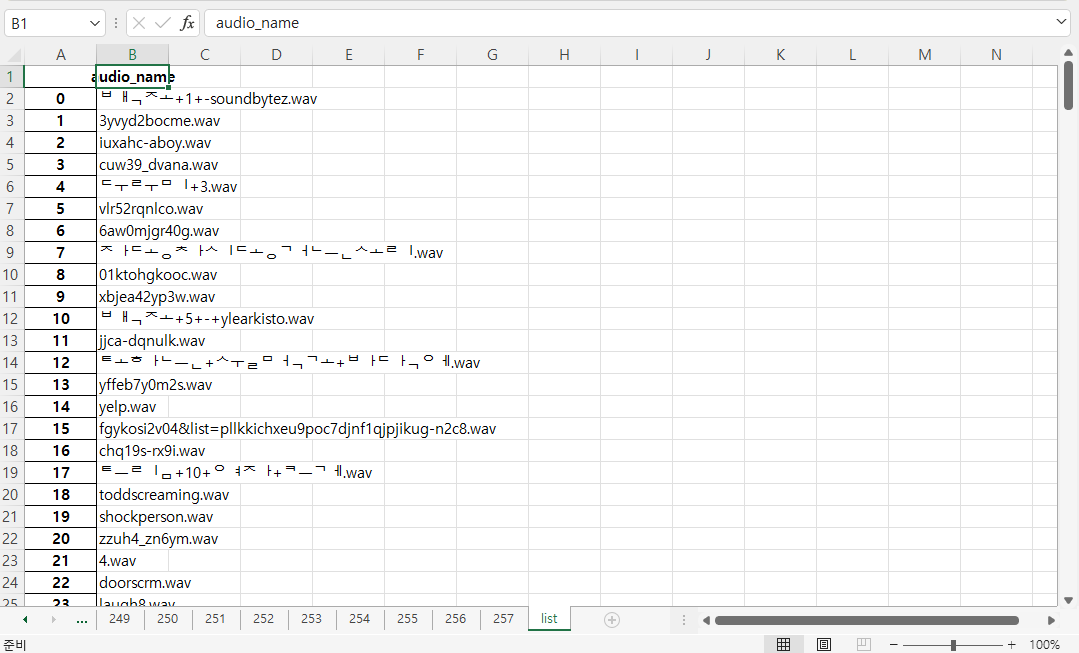

# 전체 데이터 전처리

In [1]:
import time
import math

import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa
from torch.utils.data import Dataset, DataLoader

*데이터 불러오기*

In [2]:
# 소리 데이터 로드
def load_sound_data(file_path, sampling_rate):
    audio, sr = librosa.load(file_path, sr=sampling_rate)
    return audio, sr

In [3]:
# 레이블 데이터 로드 및 일정 시간 미만의 레이블 제거
def load_label_data(file_path, i, frame_size):
    audio_label = pd.read_excel(file_path, sheet_name=str(i))  # 데이터를 정리한 엑셀 파일의 i번 sheet 덩보 불러오기
    audio_label['label'] = audio_label['label'].apply(
        lambda x: int(str(x)[0])
    )
 
    audio_label = np.array(audio_label)  # Pandas -> numpy
    audio_label = audio_label[
        (audio_label[:, 1] - audio_label[:, 0] > frame_size)
    ]                                    # 실제로 사용할 Frame size 이하 레이블은 버림
    
    return audio_label

*Frame Processing*

In [4]:
def process_frame(audio, sr, label, frame_size=1, stride=0.2):
    n = np.sum(
        np.floor(((label[:, 1] - label[:, 0]) - frame_size) / stride + frame_size)
    )                                    # 총 Frame 개수
 
    # Frame 벡터, Target벡터(Label 벡터)를 담을 빈 벡터 생성
    frame_vector = np.zeros((int(n), frame_size * sr))
    target_vector = np.zeros((int(n), 1))
 
    i = 0
    for temp_label in label:    # 한 개의 레이블 구간 처리
        start = temp_label[0]   # 시작시점
        end = temp_label[1]     # 종료시점
        y = temp_label[2]       # 레이블 정보
 
        eter = int(
            np.floor((((end - start) - frame_size) / stride) + 1)
        )                                # 레이블 별 Frame 개수
 
        for j in range(eter):   # 레이블 별 Frame 처리 
            start_idx = int((start + j * stride) * sr)
            end_idx = start_idx + frame_size * sr
            frame_vector[i] = audio[start_idx:end_idx]      # Frame 벡터에 값 넣기
            target_vector[i] = y    # Target 벡터에 값 넣기
            i += 1

    return frame_vector, target_vector

*Feature Extraction: Mel Spectrogram*